<a href="https://colab.research.google.com/github/TasneemElgendy/video-binary-classification-/blob/main/shop_lifter_detection_VideoMAE_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Installition:

In [ ]:
!nvidia-smi

Sat Aug 23 16:26:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install -U pip
!pip install -U transformers accelerate timm einops decord av datasets opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 109.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 101.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 49.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 108.7 MB/s  0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.2
    Uninstalling transformers-4.55.2:
      Successfully uninstalled transformers-4.55.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [transformers]


In [ ]:
!pip install gdown

In [ ]:
import gdown
import os
import zipfile
import re
import os, glob, random, csv
from pathlib import Path
from google.colab import drive
from collections import defaultdict
from decord import VideoReader
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from decord import VideoReader, cpu
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, VideoMAEForVideoClassification


In [ ]:
import torch, transformers, platform, sys
print("PyTorch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("Python:", sys.version)
print("OS:", platform.platform())


PyTorch: 2.8.0+cu126
Transformers: 4.55.4
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
OS: Linux-6.1.123+-x86_64-with-glibc2.35


# Data Preprocessing:

In [ ]:
drive.mount('/content/drive')

In [ ]:
file_id="1NAsGMLFtE6taowhMRz06EH5_us9H8v5C"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "videos.zip", quiet=False)

In [ ]:
with zipfile.ZipFile("videos.zip", 'r') as zip_ref:
  zip_ref.extractall("extracted videos")

In [ ]:
for label in ["shop lifters", "non shop lifters"]:
    folder = os.path.join("/content/extracted videos/Shop DataSet", label)
    print(label, ":", len(os.listdir(folder)), "videos")

In [ ]:
folder_path = "/content/extracted videos/Shop DataSet/non shop lifters"
all_files = os.listdir(folder_path)
file_set = set(all_files)

for file_name in all_files:

    match = re.match(r"(shop_lifter.*)_\d+\.mp4$", file_name)
    if match:
        original_name = match.group(1) + ".mp4"
        if original_name in file_set:
            file_to_remove = os.path.join(folder_path, file_name)
            os.remove(file_to_remove)
            print(f"Deleted duplicate: {file_name}")


In [ ]:
for label in ["shop lifters", "non shop lifters"]:
    folder = os.path.join("/content/extracted videos/Shop DataSet", label)
    print(label, ":", len(os.listdir(folder)), "videos")

In [ ]:
folder_path = "/content/extracted videos/Shop DataSet/non shop lifters"
x = 0
y = 0
if os.path.exists(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".mp4"):
            x +=1
            # print(filename)
else:
    y+=1
    # print("Not Exist")
print ( "x= ", x, "y =", y)

In [ ]:
random.seed(42)
RAW_ROOT = Path("/content/extracted videos/Shop DataSet")
class_to_label = {
    "non shop lifters": 0,
    "shop lifters": 1,
}

all_samples = []
for cls, y in class_to_label.items():
    vids = sorted(
        glob.glob(str(RAW_ROOT/cls/"*.mp4"))
        + glob.glob(str(RAW_ROOT/cls/"*.avi"))
        + glob.glob(str(RAW_ROOT/cls/"*.mov"))
        + glob.glob(str(RAW_ROOT/cls/"*.mkv"))
    )
    for v in vids:
        all_samples.append((v, y))

print("Total videos:", len(all_samples))


In [ ]:
by_label = defaultdict(list)
for path, y in all_samples:
    by_label[y].append(path)

splits = {"train": [], "val": [], "test": []}

for y, paths in by_label.items():
    random.shuffle(paths)
    n = len(paths)
    n_train = int(0.8*n)
    n_val = int(0.1*n)
    train_paths = paths[:n_train]
    val_paths = paths[n_train:n_train+n_val]
    test_paths = paths[n_train+n_val:]

    splits["train"] += [(p, y) for p in train_paths]
    splits["val"]   += [(p, y) for p in val_paths]
    splits["test"]  += [(p, y) for p in test_paths]

for k in splits:
    print(k, len(splits[k]))

In [ ]:
OUT_DIR = Path("/content/drive/MyDrive/Cellula internship/Week5")
OUT_DIR.mkdir(parents=True, exist_ok=True)

for split in ["train","val","test"]:
    with open(OUT_DIR/f"{split}.csv", "w", newline='', encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["filepath","label"])
        for path, y in splits[split]:
            w.writerow([path, y])

print("Written:", list(OUT_DIR.glob("*.csv")))

In [ ]:
def is_video_ok(path):
    try:
        vr = VideoReader(path)
        _ = len(vr)
        return _ > 0
    except Exception:
        return False

def filter_csv(csv_path):
    df = pd.read_csv(csv_path)
    keep = []
    for i,(fp, y) in enumerate(df[["filepath","label"]].values):
        if i % 50 == 0:
            print(f"{csv_path.name}: checking {i}/{len(df)}")
        if os.path.exists(fp) and is_video_ok(fp):
            keep.append((fp, y))
    new_path = csv_path.with_suffix(".clean.csv")
    pd.DataFrame(keep, columns=["filepath","label"]).to_csv(new_path, index=False)
    print("Cleaned ->", new_path)
    return new_path

clean_csvs = []
for split in ["train","val","test"]:
    clean_csvs.append(filter_csv(OUT_DIR/f"{split}.csv"))

clean_csvs

# Model Fine-tuning:

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "MCG-NJU/videomae-base"

# processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
model = VideoMAEForVideoClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

print("Loaded model on:", device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/377M [00:00<?, ?B/s]

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded model on: cuda


In [ ]:
class VideoCSVDataset(Dataset):
    def __init__(self, csv_file, num_frames=16, frame_sample="uniform"):
        self.df = pd.read_csv(csv_file)
        self.num_frames = num_frames
        self.frame_sample = frame_sample

    def __len__(self):
        return len(self.df)

    def _sample_indices(self, num_total):
        n = self.num_frames
        if num_total <= n:
            idx = list(range(num_total)) + [num_total-1]*(n - num_total)
            return np.array(idx)
        if self.frame_sample == "uniform":
            return np.linspace(0, num_total-1, n, dtype=int)
        else:
            return np.sort(np.random.choice(num_total, n, replace=False))

    def __getitem__(self, idx):
        fp, label = self.df.iloc[idx][["filepath","label"]]
        vr = VideoReader(fp, ctx=cpu(0))
        total = len(vr)
        frame_idxs = self._sample_indices(total)
        frames = vr.get_batch(frame_idxs).asnumpy()  # shape: (T, H, W, C), uint8
        return frames, int(label)

In [ ]:
# ImageNet normalization values
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def preprocess_video(frames, size=224):
    frames = torch.tensor(frames, dtype=torch.float32) / 255.0
    frames = frames.permute(0, 3, 1, 2)  # (T, H, W, C) -> (T, C, H, W)
    frames = F.interpolate(frames, size=(size, size), mode="bilinear", align_corners=False) # Resize each frame to 224x224
    frames = (frames - IMAGENET_MEAN) / IMAGENET_STD # Normalize

    # Final shape: (T, C, H, W)
    return frames


def collate_fn(batch):
    videos, labels = zip(*batch)
    processed_videos = [preprocess_video(v) for v in videos]  # list of (T,C,H,W)

    # Stack into a batch
    pixel_values = torch.stack(processed_videos)  # (B,T,C,H,W)
    labels = torch.tensor(labels, dtype=torch.long)
    return pixel_values, labels


In [ ]:
train_csv = "/content/drive/MyDrive/Cellula internship/Week5/train.clean.csv"
datasett = VideoCSVDataset(train_csv, num_frames=16, frame_sample="uniform")
train_dataloader = DataLoader( datasett, batch_size=4, shuffle=True, collate_fn=collate_fn )

for videos, labels in train_dataloader:
   print("Videos shape:", videos.shape) # (B,T,C,H,W)
   print("Labels shape:", labels.shape) # (B,)
   break

Videos shape: torch.Size([4, 16, 3, 224, 224])
Labels shape: torch.Size([4])


In [ ]:
val_csv = "/content/drive/MyDrive/Cellula internship/Week5/val.clean.csv"
datasetv = VideoCSVDataset(val_csv, num_frames=16, frame_sample="uniform")
val_dataloader = DataLoader( datasetv, batch_size=4, shuffle=False, collate_fn=collate_fn )

for videos, labels in val_dataloader:
   print("Videos shape:", videos.shape) # (B,T,C,H,W)
   print("Labels shape:", labels.shape) # (B,)
   break

Videos shape: torch.Size([4, 16, 3, 224, 224])
Labels shape: torch.Size([4])


In [ ]:
test_csv  = "/content/drive/MyDrive/Cellula internship/Week5/test.clean.csv"
test_dataset  = VideoCSVDataset(test_csv, num_frames=16, frame_sample="uniform")
test_dataloader  = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


for videos, labels in test_dataloader:
   print("Videos shape:", videos.shape) # (B,T,C,H,W)
   print("Labels shape:", labels.shape) # (B,)
   break

Videos shape: torch.Size([4, 16, 3, 224, 224])
Labels shape: torch.Size([4])


In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
num_epochs = 5
num_training_steps = len(train_dataloader) * num_epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)


In [ ]:

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for videos, labels in loop:
        videos, labels = videos.to(device), labels.to(device)

        outputs = model(pixel_values=videos, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_dataloader)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for videos, labels in val_dataloader:
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(pixel_values=videos)
            preds = outputs.logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f} | Val Acc={val_acc:.4f}")


Epoch 1/5: 100%|██████████| 128/128 [06:58<00:00,  3.27s/it, loss=0.0848]


Epoch 1: Train Loss=0.5514 | Val Acc=0.9683


Epoch 2/5: 100%|██████████| 128/128 [06:28<00:00,  3.04s/it, loss=0.00236]


Epoch 2: Train Loss=0.1181 | Val Acc=0.9841


Epoch 3/5: 100%|██████████| 128/128 [06:41<00:00,  3.14s/it, loss=0.00189]


Epoch 3: Train Loss=0.0277 | Val Acc=1.0000


Epoch 4/5: 100%|██████████| 128/128 [06:32<00:00,  3.07s/it, loss=0.00036]


Epoch 4: Train Loss=0.0165 | Val Acc=1.0000


Epoch 5/5: 100%|██████████| 128/128 [06:25<00:00,  3.01s/it, loss=0.000329]


Epoch 5: Train Loss=0.0018 | Val Acc=1.0000


In [ ]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for videos, labels in test_dataloader:
        videos, labels = videos.to(device), labels.to(device)
        outputs = model(pixel_values=videos)
        preds = outputs.logits.argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"Final Test Accuracy: {test_acc:.4f}")


Final Test Accuracy: 1.0000


In [ ]:
# After the test loop
print("\nClassification Report:")
print(classification_report(labels.cpu().numpy(), preds.cpu().numpy()))


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [ ]:
model.save_pretrained("videomae-shoplifting")

## Test example:

In [ ]:
frames, true_label = test_dataset[0]
print(f"Selected a test sample with shape: {frames.shape}")
print(f"True label: {true_label}")

Selected a test sample with shape: (16, 576, 704, 3)
True label: 0


In [ ]:
processed_videos = preprocess_video(frames)
processed_videos = processed_videos.unsqueeze(0)
print("Processed video shape:", processed_videos.shape)

Processed video shape: torch.Size([1, 16, 3, 224, 224])


In [ ]:
class_to_label = {
    "non shop lifters": 0,
    "shop lifters": 1,
}

model.eval()
with torch.no_grad():
    videos = processed_videos.to(device)
    outputs = model(pixel_values=videos)
    preds = outputs.logits.argmax(dim=-1)
    predicted_label = preds.item()
key = [k for k, v in class_to_label.items() if v == predicted_label][0]
print(f"Predicted label: {key}")

Predicted label: non shop lifters


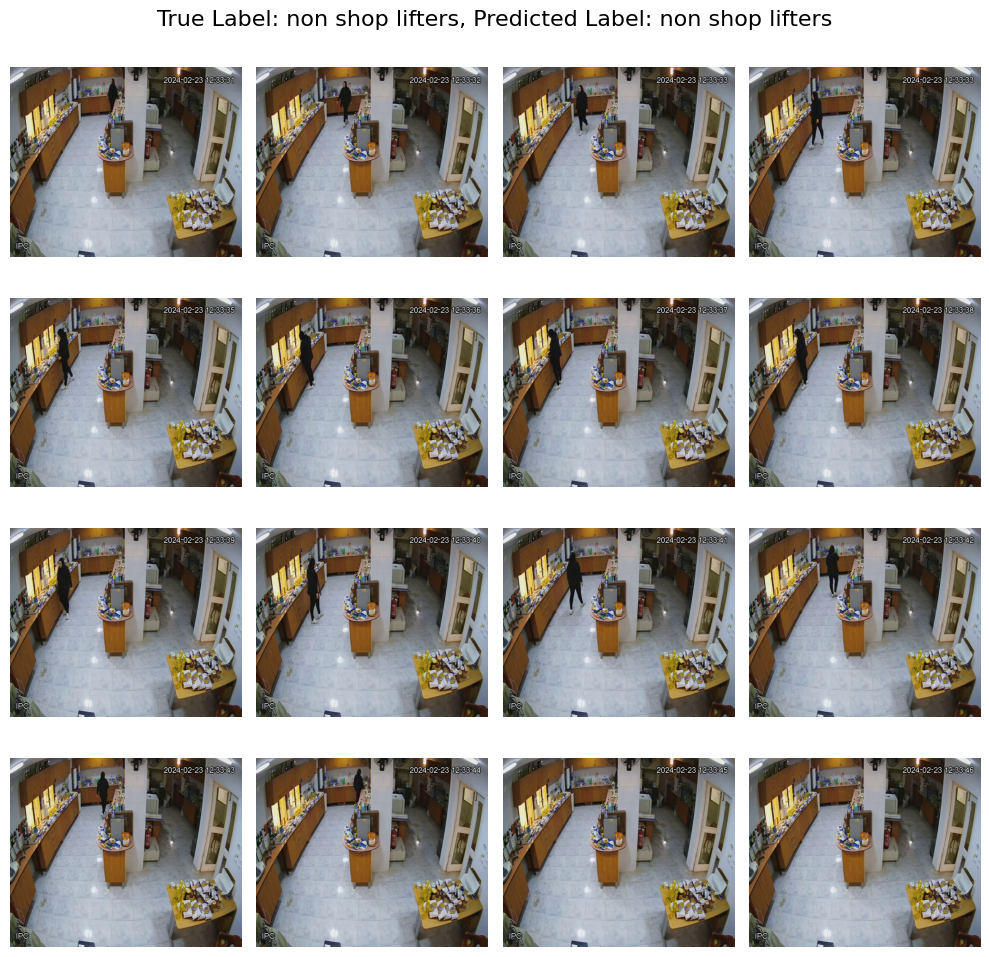

True Label: non shop lifters
Predicted Label: non shop lifters


In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(frames.shape[0]):
    ax = axes[i]
    ax.imshow(frames[i])
    ax.axis('off')
true_key = [k for k, v in class_to_label.items() if v == true_label][0]
predicted_key = [k for k, v in class_to_label.items() if v == predicted_label][0]
fig.suptitle(f"True Label: {true_key}, Predicted Label: {predicted_key}", fontsize=16)
plt.tight_layout()
plt.show()

print(f"True Label: {true_key}")
print(f"Predicted Label: {predicted_key}")

# whyyyyy?

In [ ]:
# def collate_fn(batch):
#     videos, labels = zip(*batch)  # videos: tuple of (T,H,W,C)
#     # processor يتوقع list of arrays (T,H,W,C)
#     inputs = processor(list(videos), return_tensors="pt")
#     # pixel_values: (B, C, T, H, W)
#     labels = torch.tensor(labels, dtype=torch.long)
#     return inputs["pixel_values"], labels

In [ ]:
# train_csv = "/content/drive/MyDrive/Cellula internship/Week5/train.clean.csv"
# dataset = VideoCSVDataset(train_csv, num_frames=16, frame_sample="uniform")
# dataloader = DataLoader( dataset, batch_size=4, shuffle=True, collate_fn=collate_fn )
# processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

# for videos, labels in dataloader:
#    print("Videos shape:", videos.shape) # (B, T, H, W, C)
#    print("Labels shape:", labels.shape) # (B,)
#    break

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


TypeError: Cannot handle this data type: (1, 1, 704, 3), |u1